<font face="Nunito" size=4>Making Code re-usable & Testing Actual Data
<font size=3><br>
    In this draft of the code we will
    <li> attempt to replicate things form the previous draft but usig functions instead of plain code out in the open
    <li> use the same dat that will beused in the project
    <li> Expand on the number and types of graphs we have to explain and compare our results
    <li> Hopefully apply these things to a different strategy
</font>
</font>

- At least one stock
- At least one index
- Hourly data
- Simple Moving Average indicator crossover rules
  - SMA-30
  - SMA-50


$Simple~Moving~Average$

> A lax *crossover* signal is adapted by referring to is the past 30 periods simple moving average of prices (SMA-**30**) is
above or below the past 50 periods simple moving average of prices (SMA-**50**). A buy (sell) signal is taken to have been generated when the SMA-**30** exceeds (drops below) the SMA-**50**.


- (i) When the SMA-30 crosses above the SMA-50, this constitutes a buy signal and any short positions are closed and a long position is opened.
- (ii) When the SMA-30 crosses below the SMA-50, this constitutes a buy signal and any long positions are closed and a short position is opened

$Volatility~Filter~–~Average~True~Range~(ATR)$


Current ATR = \[ ( Prior ATR × (n − 1)) + Current TR \] $\div$ n *$~~~~$ formula (1)*

where $n$ is the user-defined number of periods,

Current TR = Max(−Current Low, Current High − Previous Close, Current Low − Previous Close) *$~~~~$ formula (2)*

<font face="Nunito" size=4>0. Imports</font>

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
plt.style.use("fivethirtyeight")
%matplotlib inline

<font face="Nunito" size=4>I. Load Data into a DataFrame<br><br>
<font size=3>
We will be using the following data:
    <li> Hourly data from the S\&P500,from 1998-01-02 9am to 2020-03-09 3pm, from the QuantConnect [Lean pacakge Github](https://github.com/QuantConnect/Lean)
    <li> Daily data from the S\&P500, from 2007-01-03 to 2020-12-31, from [Yahoo! Finance](https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC)

Data will be trimmed in order to compare across the same ranges.
</font>
</font>

QuantConnect Data:
- columns: time, close, high, low, open, volume
- dates: as listed above
- For some reason, the values of Close, High, Low, Open are multiplied by 1000. We'll divided ot make them match the Yahoo! data.

Yahoo!Finance
- columns: date, open, high, low, close, adj close, volume
- dates: as listed above
- ticker in Yahoo! Finance: ^GSPC


In [82]:
# QC
# The QuantConnect data doesn't have headers, so we add some.
# We use converters to handle the x1000 issue with the index values.
# We do not import the volume column.
f00 = lambda str_num: (int(str_num)/1000)
qcdf = pd.read_csv("data_files/quantconnect_hourly_spy.csv",parse_dates=[0],
                   names=["time", "close", "high", "low", "open"],
                   usecols=range(5),
                   converters={"close":f00, "high":f00, "low":f00, "open":f00})
# YF
yfdf = pd.read_csv("data_files/YFSnp500_2007-20_GSPC.csv",parse_dates=[0],
                   names=["date", "open", "high", "low", "close", "adjClose"],
                   header=0, # explicitly says the first row is a header so we can override the names
                   usecols=range(6))
#yfdf.drop(columns="close",inplace=True)

- Acsending order

In [83]:
qcdf[qcdf.time >= "2007-01-03"]

,time,close,high,low,open
15814,2007-01-03 09:00:00,1422.7,1427.8,1419.3,1423.0
15815,2007-01-03 10:00:00,1420.5,1428.4,1419.9,1425.8
15816,2007-01-03 11:00:00,1425.8,1427.0,1425.1,1425.9
15817,2007-01-03 12:00:00,1425.8,1426.9,1423.9,1425.9
15818,2007-01-03 13:00:00,1425.6,1426.0,1420.0,1420.5
...,...,...,...,...,...
38950,2020-03-09 11:00:00,2786.1,2840.8,2780.2,2827.0
38951,2020-03-09 12:00:00,2826.9,2841.4,2790.1,2797.1
38952,2020-03-09 13:00:00,2796.8,2807.1,2753.5,2758.5
38953,2020-03-09 14:00:00,2758.2,2776.3,2734.6,2765.9


- verify that the datetimein the QuantConnect data is indeed a datetime object

In [84]:
qcdf.time[0]

Timestamp('1998-01-02 09:00:00')

In [85]:
yfdf

,date,open,high,low,close,adjClose
0,2007-01-03,1418.030029,1429.420044,1407.859985,1416.599976,1416.599976
1,2007-01-04,1416.599976,1421.839966,1408.430054,1418.339966,1418.339966
2,2007-01-05,1418.339966,1418.339966,1405.750000,1409.709961,1409.709961
3,2007-01-08,1409.260010,1414.979980,1403.969971,1412.839966,1412.839966
4,2007-01-09,1412.839966,1415.609985,1405.420044,1412.109985,1412.109985
...,...,...,...,...,...,...
3520,2020-12-24,3694.030029,3703.820068,3689.320068,3703.060059,3703.060059
3521,2020-12-28,3723.030029,3740.510010,3723.030029,3735.360107,3735.360107
3522,2020-12-29,3750.010010,3756.120117,3723.310059,3727.040039,3727.040039
3523,2020-12-30,3736.189941,3744.629883,3730.209961,3732.040039,3732.040039


- Since the data on the S&P 500 comes from two different sources, QuantConnect and Yahoo!Finance, we will observe differences in the OHLC values. 
- This isn not an issuse for what we'd like to test.

<font face="Nunito" size=4>II. Visually Show the Close Price</font>

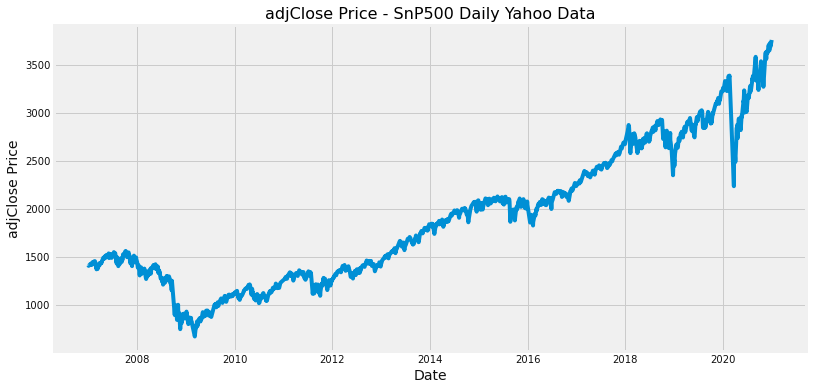

In [86]:
plt.figure(figsize=(12,6))
plt.title("adjClose Price - SnP500 Daily Yahoo Data", fontsize=16)
plt.plot(yfdf["date"], yfdf.adjClose)
plt.xlabel("Date", fontsize=14)
plt.ylabel("adjClose Price", fontsize=14)
plt.show()

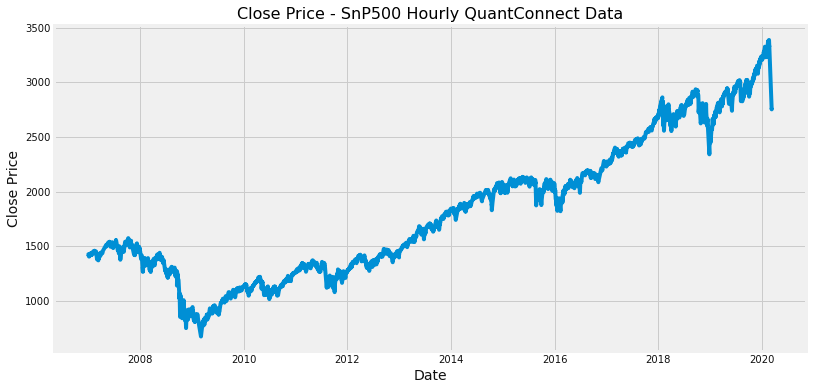

In [87]:
plt.figure(figsize=(12,6))
plt.title("Close Price - SnP500 Hourly QuantConnect Data", fontsize=16)

toplot = qcdf[["time","close"]][qcdf.time >= "2007-01-03"]

plt.plot(toplot.time ,toplot.close)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Close Price", fontsize=14)
plt.show()

<font face="Nunito" size=4>III. Calculate the 3 Moving Averages</font>

$Simple~Moving~Average$

> A lax *crossover* signal is adapted by referring to is the past 30 periods simple moving average of prices (SMA-**30**) is
above or below the past 50 periods simple moving average of prices (SMA-**50**). A buy (sell) signal is taken to have been generated when the SMA-**30** exceeds (drops below) the SMA-**50**.


- (i) When the SMA-30 crosses above the SMA-50, this constitutes a buy signal and any short positions are closed and a long position is opened.
- (ii) When the SMA-30 crosses below the SMA-50, this constitutes a buy signal and any long positions are closed and a short position is opened

In [88]:
# SMA-30 and SMA-50 for daily data
daySMA30 = yfdf.adjClose.rolling(window=30,).mean()
daySMA50 = yfdf.adjClose.rolling(window=50).mean()

# SMA-30 and SMA-50 for hourly dats (where the periods are each hour)
hrSMA30 = qcdf.close.rolling(window=30).mean()
hrSMA50 = qcdf.close.rolling(window=50).mean()

<font face="Nunito" size=4>IV. Visualize the Closing Price along with the Moving Averages</font>

In [89]:
yfdf["sma30"] = daySMA30
yfdf["sma50"] = daySMA50
qcdf["sma30"] = hrSMA30
qcdf["sma50"] = hrSMA50

In [90]:
yfdf

,date,open,high,low,close,adjClose,sma30,sma50
0,2007-01-03,1418.030029,1429.420044,1407.859985,1416.599976,1416.599976,NaN,NaN
1,2007-01-04,1416.599976,1421.839966,1408.430054,1418.339966,1418.339966,NaN,NaN
2,2007-01-05,1418.339966,1418.339966,1405.750000,1409.709961,1409.709961,NaN,NaN
3,2007-01-08,1409.260010,1414.979980,1403.969971,1412.839966,1412.839966,NaN,NaN
4,2007-01-09,1412.839966,1415.609985,1405.420044,1412.109985,1412.109985,NaN,NaN
...,...,...,...,...,...,...,...,...
3520,2020-12-24,3694.030029,3703.820068,3689.320068,3703.060059,3703.060059,3650.491333,3563.210796
3521,2020-12-28,3723.030029,3740.510010,3723.030029,3735.360107,3735.360107,3657.103003,3568.251196
3522,2020-12-29,3750.010010,3756.120117,3723.310059,3727.040039,3727.040039,3661.832674,3573.115796
3523,2020-12-30,3736.189941,3744.629883,3730.209961,3732.040039,3732.040039,3665.337012,3579.218198


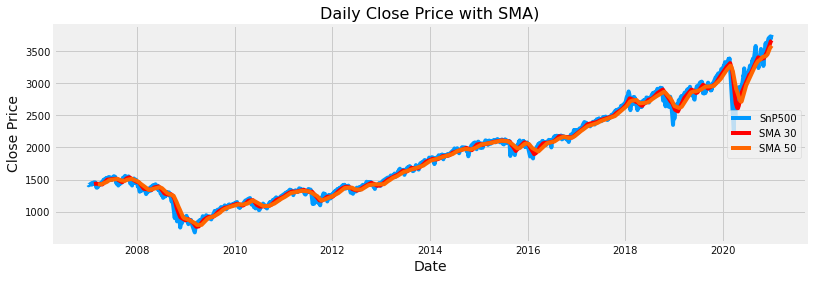

In [91]:
plt.figure(figsize=(12,4))
plt.title("Daily Close Price with SMA)", fontsize=16)
plt.plot(yfdf.date,yfdf.adjClose, label = "SnP500", color="#0099ff")
# Now plot the EMA data
plt.plot(yfdf.date,yfdf.sma30, label = "SMA 30", color="red")
plt.plot(yfdf.date,yfdf.sma50, label = "SMA 50", color="#ff6600")
# ----
plt.xlabel("Date",fontsize=14)
plt.ylabel("Close Price", fontsize=14)
plt.legend(loc="center right")
plt.show()

In [92]:
# trim qcdf to start from 2007-01-03
qcdf2 = qcdf.copy()
qcdf2 = qcdf2[qcdf.time >= "2007-01-03"]

In [93]:
qcdf2

,time,close,high,low,open,sma30,sma50
15814,2007-01-03 09:00:00,1422.7,1427.8,1419.3,1423.0,1419.340000,1418.986
15815,2007-01-03 10:00:00,1420.5,1428.4,1419.9,1425.8,1419.673333,1418.938
15816,2007-01-03 11:00:00,1425.8,1427.0,1425.1,1425.9,1420.260000,1418.950
15817,2007-01-03 12:00:00,1425.8,1426.9,1423.9,1425.9,1420.716667,1418.946
15818,2007-01-03 13:00:00,1425.6,1426.0,1420.0,1420.5,1421.210000,1418.948
...,...,...,...,...,...,...,...
38950,2020-03-09 11:00:00,2786.1,2840.8,2780.2,2827.0,2999.220000,2994.432
38951,2020-03-09 12:00:00,2826.9,2841.4,2790.1,2797.1,2991.473333,2989.864
38952,2020-03-09 13:00:00,2796.8,2807.1,2753.5,2758.5,2981.240000,2984.492
38953,2020-03-09 14:00:00,2758.2,2776.3,2734.6,2765.9,2970.738333,2978.090


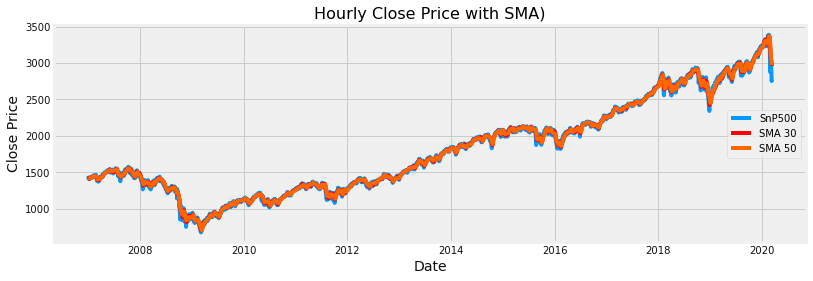

In [94]:
plt.figure(figsize=(12,4))
plt.title("Hourly Close Price with SMA)", fontsize=16)
plt.plot(qcdf2.time,qcdf2.close, label = "SnP500", color="#0099ff")
# Now plot the EMA data
plt.plot(qcdf2.time,qcdf2.sma30, label = "SMA 30", color="red")
plt.plot(qcdf2.time,qcdf2.sma50, label = "SMA 50", color="#ff6600")
# ----
plt.xlabel("Date",fontsize=14)
plt.ylabel("Close Price", fontsize=14)
plt.legend(loc="center right")
plt.show()

<font face="Nunito" size=4>V. Create the columns for Volatility<br>
<font size=3>Our data is in ascending order. We will `shift()` a series of indicators *down* by one row, such that<br>
&emsp;&emsp; - the indicator for day X is aligned with the data/price for day X+1<br>
&emsp;&emsp; - (alt: the indictor for day X-1 is aligned with data for day X<br>
<br></font></font>




</font>

- We will calculate volatility on log returns, which means we need to calculate log returns as an intermediate step.

###################################

# using qcdf2 and yfdf
yfdf["pctRet"] = np.log(yfdf.close/yfdf.close.shift())
yfdf.head()
# ---

################################

# ---- qcdf2 data
qcdf2["pctRet"] = np.log(qcdf2.close/qcdf2.close.shift())
qcdf2.head()

In [95]:
yfdf["pctRet"] = yfdf.close.pct_change()

In [96]:
yfdf.head()

,date,open,high,low,close,adjClose,sma30,sma50,pctRet
0,2007-01-03,1418.030029,1429.420044,1407.859985,1416.599976,1416.599976,NaN,NaN,NaN
1,2007-01-04,1416.599976,1421.839966,1408.430054,1418.339966,1418.339966,NaN,NaN,0.001228
2,2007-01-05,1418.339966,1418.339966,1405.750000,1409.709961,1409.709961,NaN,NaN,-0.006085
3,2007-01-08,1409.260010,1414.979980,1403.969971,1412.839966,1412.839966,NaN,NaN,0.002220
4,2007-01-09,1412.839966,1415.609985,1405.420044,1412.109985,1412.109985,NaN,NaN,-0.000517


- Our Volatility Inidcator is the Average True Range, using periods of n=10 and n=20

For daily data, this will be 10 and 20 days. For hourly data this this be 10 and 20 hours.

Current TR = Max:
 - $Current~High~−~Current~Low$, 
 - $Current~High~−~Previous~Close$ (absolute value), 
 - $Current~Low~−~Previous~Close$ (absolute value)

In [97]:
def trueRange (theDate, closeP, highP, lowP, openP, prevClose):
    x1 = highP - lowP
    x2 = abs(highP - prevClose)
    x3 = abs(lowP - prevClose)
    
    #print(f"{x1}\t{x2}\t{x3}")

    # return max(x1, x2, x3)
    if x2 <= x1 >= x3:
        tRng = x1
    elif x1 <= x2 >= x3:
        tRng = x2
    elif x1 <= x3 >= x2:
        tRng = x3
    
    #print(theDate,tRng)
    return theDate, tRng

In [98]:
ct = 1
tRngDates = []
tRngValues = []
while ct < len(yfdf.date):
    trd,trv = trueRange(yfdf.date[ct],
                        yfdf.close[ct],
                        yfdf.high[ct],
                        yfdf.low[ct],
                        yfdf.open[ct],
                        yfdf.close[ct-1],
                       )
    tRngDates.append(trd)
    tRngValues.append(trv)
    ct +=1

In [99]:
tRngValues[:6]

[13.409912000000077,
 12.589966000000004,
 11.010009000000082,
 10.18994100000009,
 10.670043999999962,
 12.280029000000013]

- The ATR will be the True Range series, with the rolling window mean applied to it for a window of 10 or 20

In [100]:
len(tRngValues)

3524

In [101]:
len(yfdf.close)

3525

In [102]:
temp1 = [np.nan] + tRngValues
yfdf["true_range"] = temp1
yfdf.head()

,date,open,high,low,close,adjClose,sma30,sma50,pctRet,true_range
0,2007-01-03,1418.030029,1429.420044,1407.859985,1416.599976,1416.599976,NaN,NaN,NaN,NaN
1,2007-01-04,1416.599976,1421.839966,1408.430054,1418.339966,1418.339966,NaN,NaN,0.001228,13.409912
2,2007-01-05,1418.339966,1418.339966,1405.750000,1409.709961,1409.709961,NaN,NaN,-0.006085,12.589966
3,2007-01-08,1409.260010,1414.979980,1403.969971,1412.839966,1412.839966,NaN,NaN,0.002220,11.010009
4,2007-01-09,1412.839966,1415.609985,1405.420044,1412.109985,1412.109985,NaN,NaN,-0.000517,10.189941


In [103]:
yfdf["ATR10"] = yfdf.true_range.rolling(window=10, min_periods=0).mean()
yfdf["ATR20"] = yfdf.true_range.rolling(window=20, min_periods=0).mean()

In [104]:
yfdf.iloc[7:23,-6:]

,sma30,sma50,pctRet,true_range,ATR10,ATR20
7,NaN,NaN,0.004853,8.650024,11.257132,11.257132
8,NaN,NaN,0.000818,5.310059,10.513748,10.513748
9,NaN,NaN,-0.000894,6.700074,10.090006,10.090006
10,NaN,NaN,-0.002971,8.750000,9.956006,9.956006
11,NaN,NaN,0.002895,6.380005,9.253015,9.630915
12,NaN,NaN,-0.005278,10.989991,9.093018,9.744171
13,NaN,NaN,0.003542,9.669922,8.959009,9.738460
14,NaN,NaN,0.008501,12.180054,9.158020,9.912859
15,NaN,NaN,-0.011270,18.349975,9.926013,10.475334
16,NaN,NaN,-0.001208,10.310059,9.729016,10.465004


**** <font face="Nunito" size=4>V. Align the SMAs to the dates they will be predicting for
<font size=3>Our data is in ascending order. We will `shift()` a series of indicators *down* by one row, such that<br>
&emsp;&emsp; - the indicator for day X is aligned with the data/price for day X+1<br>
&emsp;&emsp; - (alt: the indictor for day X-1 is aligned with data for day X<br>
<br></font></font>




</font>

In [105]:
yfdf.head()

,date,open,high,low,close,adjClose,sma30,sma50,pctRet,true_range,ATR10,ATR20
0,2007-01-03,1418.030029,1429.420044,1407.859985,1416.599976,1416.599976,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-01-04,1416.599976,1421.839966,1408.430054,1418.339966,1418.339966,NaN,NaN,0.001228,13.409912,13.409912,13.409912
2,2007-01-05,1418.339966,1418.339966,1405.750000,1409.709961,1409.709961,NaN,NaN,-0.006085,12.589966,12.999939,12.999939
3,2007-01-08,1409.260010,1414.979980,1403.969971,1412.839966,1412.839966,NaN,NaN,0.002220,11.010009,12.336629,12.336629
4,2007-01-09,1412.839966,1415.609985,1405.420044,1412.109985,1412.109985,NaN,NaN,-0.000517,10.189941,11.799957,11.799957


In [106]:
# We shift the SMA, True Range and ATR columns
yfdf.sma30 = yfdf.sma30.shift()
yfdf.sma50 = yfdf.sma50.shift()
#yfdf.pctRet = yfdf.pctRet.shift()
yfdf.true_range = yfdf.true_range.shift()
yfdf.ATR10 = yfdf.ATR10.shift()
yfdf.ATR20 = yfdf.ATR20.shift()

In [107]:
yfdf

,date,open,high,low,close,adjClose,sma30,sma50,pctRet,true_range,ATR10,ATR20
0,2007-01-03,1418.030029,1429.420044,1407.859985,1416.599976,1416.599976,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-01-04,1416.599976,1421.839966,1408.430054,1418.339966,1418.339966,NaN,NaN,0.001228,NaN,NaN,NaN
2,2007-01-05,1418.339966,1418.339966,1405.750000,1409.709961,1409.709961,NaN,NaN,-0.006085,13.409912,13.409912,13.409912
3,2007-01-08,1409.260010,1414.979980,1403.969971,1412.839966,1412.839966,NaN,NaN,0.002220,12.589966,12.999939,12.999939
4,2007-01-09,1412.839966,1415.609985,1405.420044,1412.109985,1412.109985,NaN,NaN,-0.000517,11.010009,12.336629,12.336629
...,...,...,...,...,...,...,...,...,...,...,...,...
3520,2020-12-24,3694.030029,3703.820068,3689.320068,3703.060059,3703.060059,3646.144661,3558.922993,0.003537,23.979980,37.410034,34.673523
3521,2020-12-28,3723.030029,3740.510010,3723.030029,3735.360107,3735.360107,3650.491333,3563.210796,0.008723,14.500000,35.529028,34.511523
3522,2020-12-29,3750.010010,3756.120117,3723.310059,3727.040039,3727.040039,3657.103003,3568.251196,-0.002227,37.449951,35.804004,35.635022
3523,2020-12-30,3736.189941,3744.629883,3730.209961,3732.040039,3732.040039,3661.832674,3573.115796,0.001342,32.810058,33.908008,35.077515


<font face="Nunito" size=4>VI. Create the Function to Buy and Sell the Stock (i.e. the Strategy)<br><br>
<font size=3>Our data is in ascending order. We will later on `shift()` a series of indicators *down* by one row, such that<br>
&emsp;&emsp; - the indicator for day X is aligned with the data/price for day X+1<br>
&emsp;&emsp; - (alt: the indictor for day X-1 is aligned with data for day X<br>
<br></font></font>

Therfore, we will do this in two parts.
- First: Create the BUY/SELL criteria/indicator/signals. With DataFrames this is sometimes called a *mask*.
- Second: Apply the (boolean) mask to the correct row of data to simulate the buy/sell at that price.



#### VI-0: Strategy Recap and Reformat

Strategy I: SMA
- Buy, Close Short: SMA 30 > SMA 50
- Sell, Close Long: SMA 30 < SMA 50

Strategy II: SMA + ATR
- Buy, Close Short: SMA 30 > SMA 50 and ATR > T
- Sell, Close Long: SMA 30 < SMA 50 and ATR > T
- where T is the True Range

Strategy III: SMA + Reverse ATR (reverse Buy/Sell decision of Strategy II)
- Sell, Close Long: SMA 30 > SMA 50 and ATR > T
- Buy, Close Shirt: SMA 30 < SMA 50 and ATR > T
- where T is the True Range

Strategy IV: SMA + ATR of ATR

Strategy V: Buy and Hold

#### VI-1: Create the Buy and Sell Indicator/Flags/Mask

In [108]:
# return True or False if we should buy/sell on that date.
#
# Strategy I. 2285 occurences of sm30>sma50
s1buy = yfdf.sma30 >  yfdf.sma50
s1sell = np.logical_not(s1buy)

# Strategy II
s2buy10 = (yfdf.sma30 >  yfdf.sma50) & (yfdf.ATR10 > yfdf.true_range)
s2buy20 = (yfdf.sma30 >  yfdf.sma50) & (yfdf.ATR20 > yfdf.true_range)

s2sell10 = (yfdf.sma30 <=  yfdf.sma50) & (yfdf.ATR10 > yfdf.true_range)
s2sell20 = (yfdf.sma30 <=  yfdf.sma50) & (yfdf.ATR20 > yfdf.true_range)


# Strategy III
s3buy10 = np.logical_not(s2buy10)
s3buy20 = np.logical_not(s2buy20)

s3sell10 = np.logical_not(s2sell10)
s3sell20 = np.logical_not(s2sell20)

In [109]:
# Strategy IV

    # Create ATR of ATR
# First number is the Window. Second number is the ATR ype we are averaging over
ATR10of10 = yfdf.ATR10.rolling(window=10, min_periods=0).mean() # aa
ATR10of20 = yfdf.ATR20.rolling(window=10, min_periods=0).mean() # ab
ATR20of10 = yfdf.ATR10.rolling(window=20, min_periods=0).mean() # ba
ATR20of20 = yfdf.ATR10.rolling(window=20, min_periods=0).mean() # bb

    # Create True False mask
s4buy10aa = s1buy & (ATR10of10 > yfdf.ATR10)
s4buy10ab = s1buy & (ATR10of20 > yfdf.ATR10)
s4buy10ba = s1buy & (ATR20of10 > yfdf.ATR10)
s4buy10bb = s1buy & (ATR20of20 > yfdf.ATR10)

s4sell10aa = s1sell & (ATR10of10 > yfdf.ATR10)
s4sell10ab = s1sell & (ATR10of20 > yfdf.ATR10)
s4sell10ba = s1sell & (ATR20of10 > yfdf.ATR10)
s4sell10bb = s1sell & (ATR20of20 > yfdf.ATR10)

    # ----------------
s4buy20aa = s1buy & (ATR10of10 > yfdf.ATR20)
s4buy20ab = s1buy & (ATR10of20 > yfdf.ATR20)
s4buy20ba = s1buy & (ATR20of10 > yfdf.ATR20)
s4buy20bb = s1buy & (ATR20of20 > yfdf.ATR20)

s4sell20aa = s1sell & (ATR10of10 > yfdf.ATR20)
s4sell20ab = s1sell & (ATR10of20 > yfdf.ATR20)
s4sell20ba = s1sell & (ATR20of10 > yfdf.ATR20)
s4sell20bb = s1sell & (ATR20of20 > yfdf.ATR20)    
# Strategy V
    # This is the log return column. 
    # Since it's log returns, we can multiply them cumulatively for a total return.

In [110]:
# Create a Decision by multiplying Buy*1 and Sell*-1 and adding them together
# decisiondict = dict.fromkeys(["s1Decision",
#                              "s2Decision10","s2Decision20",
#                              "s3Decision10","s3Decision20"

temp1 = {1:(s1buy,s1sell),
         2:((s2buy10,s2sell10),
         (s2buy20,s2sell20)),
         
         3:((s3buy10,s3sell10),
         (s3buy20,s3sell20)),
         
         41:((s4buy10aa,s4sell10aa),
         (s4buy10ab,s4sell10ab),
         (s4buy10ba,s4sell10ba),
         (s4buy10bb,s4sell10bb)),
         
         42:((s4buy20aa,s4sell20aa),
         (s4buy20ab,s4sell20ab),
         (s4buy20ba,s4sell20ba),
         (s4buy20bb,s4sell20bb))
        }

In [111]:
def createDecisionMakerSeries(toBuy,toSell):
    """Since our Buy/Sell is made from a complex statement just because Buy isn't true
    doesn't mean that we Sell. Just becuase Sell isn't true doesn't mean that we buy.
    We want to make 1 series where TrueBuy=1 TrueSell=-1 and other FalseBuy or FalseSell = 0
    
    We use ( (1*Buy) + (-1*Sell) ) to acheieve this.
    """
    return ( (1*toBuy) + (-1*toSell) )

In [112]:
d1 = {1: createDecisionMakerSeries(temp1[1][0],temp1[1][1])}

d2 = {2: (createDecisionMakerSeries(temp1[2][0][0],temp1[2][0][1]),
          createDecisionMakerSeries(temp1[2][1][0],temp1[2][1][1]))}

d3 = {3: (createDecisionMakerSeries(temp1[3][0][0],temp1[3][0][1]),
          createDecisionMakerSeries(temp1[3][1][0],temp1[3][1][1]))}

d41 = {41: (createDecisionMakerSeries(temp1[41][0][0],temp1[41][0][1]),
           createDecisionMakerSeries(temp1[41][1][0],temp1[41][1][1]),
           createDecisionMakerSeries(temp1[41][2][0],temp1[41][2][1]),
           createDecisionMakerSeries(temp1[41][3][0],temp1[41][3][1]))}

d42 = {42: (createDecisionMakerSeries(temp1[42][0][0],temp1[42][0][1]),
           createDecisionMakerSeries(temp1[42][1][0],temp1[42][1][1]),
           createDecisionMakerSeries(temp1[42][2][0],temp1[42][2][1]),
           createDecisionMakerSeries(temp1[42][3][0],temp1[42][3][1]))}

- We create a copy of our df to contiue working with

In [113]:
strategyDF = yfdf.copy()

In [114]:
# Our Decision (Dec) columns with 1 or -1 based on the given strategy
strategyDF["s1Dec"] = d1[1]

strategyDF["s2Dec_ATR10"] = d2[2][0]
strategyDF["s2Dec_ATR20"] = d2[2][1]

strategyDF["s3Dec_ATR10"] = d3[3][0]
strategyDF["s3Dec_ATR20"] = d3[3][1]


strategyDF["s4Dec_Atr10_atr10ofAtr10"] = d41[41][0]
strategyDF["s4Dec_Atr10_atr10ofAtr20"] = d41[41][1]
strategyDF["s4Dec_Atr10_atr20ofAtr10"] = d41[41][2]
strategyDF["s4Dec_Atr10_atr20ofAtr20"] = d41[41][3]

strategyDF["s4Dec_Atr20_atr10ofAtr10"] = d42[42][0]
strategyDF["s4Dec_Atr20_atr10ofAtr20"] = d42[42][1]
strategyDF["s4Dec_Atr20_atr20ofAtr10"] = d42[42][2]
strategyDF["s4Dec_Atr20_atr20ofAtr20"] = d42[42][3]

In [115]:
strategyDF.iloc[:,-13:].head()

,s1Dec,s2Dec_ATR10,s2Dec_ATR20,s3Dec_ATR10,s3Dec_ATR20,s4Dec_Atr10_atr10ofAtr10,s4Dec_Atr10_atr10ofAtr20,s4Dec_Atr10_atr20ofAtr10,s4Dec_Atr10_atr20ofAtr20,s4Dec_Atr20_atr10ofAtr10,s4Dec_Atr20_atr10ofAtr20,s4Dec_Atr20_atr20ofAtr10,s4Dec_Atr20_atr20ofAtr20
0,-1,0,0,0,0,0,0,0,0,0,0,0,0
1,-1,0,0,0,0,0,0,0,0,0,0,0,0
2,-1,0,0,0,0,0,0,0,0,0,0,0,0
3,-1,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1


#### VI-2:  Apply the (boolean) mask to the correct row of data

This was not done in the video and is extra. Now that we have signals for each day, we can use this signal to tell use what to do tomorrow. Therefore, we can consider tomorrows gain/loss our own gain/loss if we had followed the strategy.

We verified using `np.logical_not` that our Buy and Sell columns were just opposites. Again, this is ignoring day one, because all EMAs have an **equal** value on that day, and out strategy only uses $>$ or$<~$. In any case, this means we only need **one** of the columns. If Buy is `True`, we know Sell is `False`, and if Buy is `False`, we know Sell is `True`. No need to check the other column.

**Magic Formula**  
Gain or Loss / Profit or Loss/ PnL equals:  
$\Rightarrow$ (True or False inidcator yesterday) $~\times~$ Today's Price Change
- In Python `True` is `1` and `False` is `0` so `True * -4` = -4, and `False * -2.5` = 0
- Obviously the positive number case works the same way. We use this to determine PnL.
- You can use absolute change and aggregate with addition or percent change and aggreate with multiplication.

In [116]:
# we apply our masks to the log return
#def decisionAppliedtoReturns(decisionColumn,returnsColumn):
#    # a decison column contains either 1, 0, or -1
#    strategyReturns = decisionColumn * returnsColumn
#    return strategyReturns

$\Uparrow$ As we can see now Buy = 1 and Sell = -1.  
We apply (multiply) these to the `pctRet` column. It actualy works that if the strategy says "Sell" (-1) and the market dropped (pctRet is negative), then we "gain" on that day.

$\Downarrow$ The strategy in action
- If we were always LONG the market/security, our PnL would mirror the `pctRet` column. Similarly it would be the opposite of the pctRet column if we were akways SHORT. Our true PnL will come from the ~sum of products of `PriceChange` and `Decicion`~ product of indidivual products of `pctRet` and a 1/-1 Buy/Sell decision.
- This product of products we will have the cumulative PnL over the entire date span

In [117]:
strategyDF.columns

Index(['date', 'open', 'high', 'low', 'close', 'adjClose', 'sma30', 'sma50',
       'pctRet', 'true_range', 'ATR10', 'ATR20', 's1Dec', 's2Dec_ATR10',
       's2Dec_ATR20', 's3Dec_ATR10', 's3Dec_ATR20', 's4Dec_Atr10_atr10ofAtr10',
       's4Dec_Atr10_atr10ofAtr20', 's4Dec_Atr10_atr20ofAtr10',
       's4Dec_Atr10_atr20ofAtr20', 's4Dec_Atr20_atr10ofAtr10',
       's4Dec_Atr20_atr10ofAtr20', 's4Dec_Atr20_atr20ofAtr10',
       's4Dec_Atr20_atr20ofAtr20'],
      dtype='object')

In [118]:
strategyDF["PnL_s1"] = strategyDF.pctRet * strategyDF.s1Dec

strategyDF["PnL_s21"] = strategyDF.pctRet * strategyDF.s2Dec_ATR10
strategyDF["PnL_s22"] = strategyDF.pctRet * strategyDF.s2Dec_ATR20

strategyDF["PnL_s31"] = strategyDF.pctRet * strategyDF.s3Dec_ATR10
strategyDF["PnL_s32"] = strategyDF.pctRet * strategyDF.s3Dec_ATR20

# Uses Strategy 4, where ATR10 is compared to the ATR of ATR
strategyDF["PnL_s41aa"] = strategyDF.pctRet * strategyDF.s4Dec_Atr10_atr10ofAtr10
strategyDF["PnL_s41ab"] = strategyDF.pctRet * strategyDF.s4Dec_Atr10_atr10ofAtr20
strategyDF["PnL_s41ba"] = strategyDF.pctRet * strategyDF.s4Dec_Atr10_atr20ofAtr10
strategyDF["PnL_s41bb"] = strategyDF.pctRet * strategyDF.s4Dec_Atr10_atr20ofAtr20

# Uses Strategy 4, where ATR20 is compared to the ATR of ATR
strategyDF["PnL_s42aa"] = strategyDF.pctRet * strategyDF.s4Dec_Atr20_atr10ofAtr10
strategyDF["PnL_s42ab"] = strategyDF.pctRet * strategyDF.s4Dec_Atr20_atr10ofAtr20
strategyDF["PnL_s42ba"] = strategyDF.pctRet * strategyDF.s4Dec_Atr20_atr20ofAtr10
strategyDF["PnL_s42bb"] = strategyDF.pctRet * strategyDF.s4Dec_Atr20_atr20ofAtr20

In [119]:
strategyDF.iloc[:,-13:].head()

,PnL_s1,PnL_s21,PnL_s22,PnL_s31,PnL_s32,PnL_s41aa,PnL_s41ab,PnL_s41ba,PnL_s41bb,PnL_s42aa,PnL_s42ab,PnL_s42ba,PnL_s42bb
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.001228,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.006085,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
3,-0.002220,0.0,0.0,0.0,0.0,-0.002220,-0.002220,-0.002220,-0.002220,-0.002220,-0.002220,-0.002220,-0.002220
4,0.000517,-0.0,-0.0,-0.0,-0.0,0.000517,0.000517,0.000517,0.000517,0.000517,0.000517,0.000517,0.000517


<div class="alert alert-warning">
Before calculating the number on the portfolio, we need to remember that certain value for or columns are irrelevant before specific dates.
    <li> Since we compare SMA 30 to SMA50 we should ignore the first 50 days of data  </li>
    <li> Since our largest ATR range is 20, we should ignore 20 days of data</li>
    <li> Appropriate PnL for "buy and hold" would start from the same trading day as the other strategies</li>
        
</div>

<font face="Nunito" size=4>VII. Plots<br><br>
<font size=3>We'd like to look at plots of the following:<br>
    <li> The points when our strategy told us to BUY (our buy signals).
    <li> The points when our strategy told us to SELL.
    <li> The days where profit was made (since losses might be more and greater)
</font>
</font>



In [120]:
# Notice row of index 29 has NaN in sma30 and row of index 49 has NaN for sma50
strategyDF.iloc[29:51,6:8]

,sma30,sma50
29,NaN,NaN
30,1431.395329,NaN
31,1432.735665,NaN
32,1433.975667,NaN
33,1435.641337,NaN
34,1437.134338,NaN
35,1438.610006,NaN
36,1439.821338,NaN
37,1440.673006,NaN
38,1439.616675,NaN


In [121]:
strategyDF.iloc[50:52,6:10]

,sma30,sma50,pctRet,true_range
50,1425.722343,1425.0978,-0.003828,10.569946
51,1423.756010,1424.5048,0.010894,13.880005


In [122]:
# Slice the DF for plotting
df1 = strategyDF.iloc[50:,:]

In [123]:
df1.columns

Index(['date', 'open', 'high', 'low', 'close', 'adjClose', 'sma30', 'sma50',
       'pctRet', 'true_range', 'ATR10', 'ATR20', 's1Dec', 's2Dec_ATR10',
       's2Dec_ATR20', 's3Dec_ATR10', 's3Dec_ATR20', 's4Dec_Atr10_atr10ofAtr10',
       's4Dec_Atr10_atr10ofAtr20', 's4Dec_Atr10_atr20ofAtr10',
       's4Dec_Atr10_atr20ofAtr20', 's4Dec_Atr20_atr10ofAtr10',
       's4Dec_Atr20_atr10ofAtr20', 's4Dec_Atr20_atr20ofAtr10',
       's4Dec_Atr20_atr20ofAtr20', 'PnL_s1', 'PnL_s21', 'PnL_s22', 'PnL_s31',
       'PnL_s32', 'PnL_s41aa', 'PnL_s41ab', 'PnL_s41ba', 'PnL_s41bb',
       'PnL_s42aa', 'PnL_s42ab', 'PnL_s42ba', 'PnL_s42bb'],
      dtype='object')

In [124]:
df1.date

50     2007-03-16
51     2007-03-19
52     2007-03-20
53     2007-03-21
54     2007-03-22
          ...    
3520   2020-12-24
3521   2020-12-28
3522   2020-12-29
3523   2020-12-30
3524   2020-12-31
Name: date, Length: 3475, dtype: datetime64[ns]

In [125]:
df2 = df1.copy()

In [126]:
df2.set_index(df2.date,inplace=True)

In [127]:
df2.drop(labels="date", axis=1, inplace=True)

In [128]:
df2.head()

,open,high,low,close,adjClose,sma30,sma50,pctRet,true_range,ATR10,...,PnL_s31,PnL_s32,PnL_s41aa,PnL_s41ab,PnL_s41ba,PnL_s41bb,PnL_s42aa,PnL_s42ab,PnL_s42ba,PnL_s42bb
date,,,,,,,,,,,,,,,,,,,,,
2007-03-16,1392.280029,1397.510010,1383.630005,1386.949951,1386.949951,1425.722343,1425.097800,-0.003828,10.569946,17.218994,...,0.003828,0.003828,-0.003828,-0.000000,-0.000000,-0.000000,-0.003828,-0.0,-0.0,-0.0
2007-03-19,1386.949951,1403.199951,1386.949951,1402.060059,1402.060059,1423.756010,1424.504800,0.010894,13.880005,16.953992,...,0.010894,0.010894,-0.010894,0.000000,0.000000,0.000000,-0.010894,0.0,0.0,0.0
2007-03-20,1402.040039,1411.530029,1400.699951,1410.939941,1410.939941,1422.211678,1424.179202,0.006333,16.250000,16.789990,...,0.006333,0.006333,-0.006333,0.000000,0.000000,0.000000,-0.006333,0.0,0.0,0.0
2007-03-21,1410.920044,1437.770020,1409.750000,1435.040039,1435.040039,1421.010010,1424.203801,0.017081,10.830078,15.489001,...,0.017081,0.017081,-0.017081,-0.017081,-0.017081,-0.017081,-0.017081,0.0,0.0,0.0
2007-03-22,1435.040039,1437.660034,1429.880005,1434.540039,1434.540039,1420.578011,1424.647803,-0.000348,28.020020,17.239002,...,-0.000000,-0.000000,0.000348,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.0


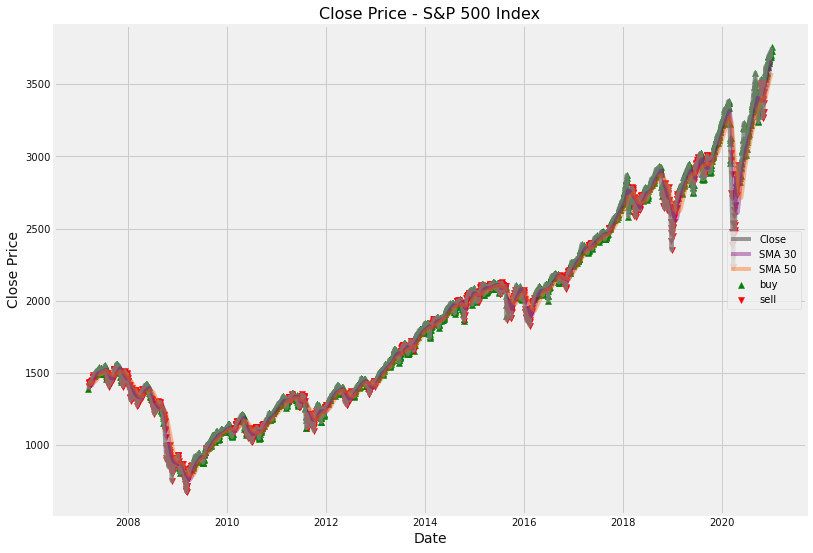

In [129]:
plt.figure(figsize=(12,9))
plt.title("Close Price - S&P 500 Index", fontsize=16)
plt.plot(df2.close, label = "Close", color="grey", alpha=0.8)
# Now plot the EMA data
plt.plot(df2.sma30, label = "SMA 30", color="purple", alpha=0.4)
plt.plot(df2.sma50, label = "SMA 50", color="#ff6600", alpha=0.4)
#plt.plot(df2.LEMA, label = "Long EMA", color="#ffff00", alpha=0.4 
#         ,linewidth=2
#         ,path_effects=[pe.Stroke(linewidth=4, foreground='#cccc00'), pe.Normal()])
# ----

# Now let's plot the Buy and Sell signals
    # we need to revoer the price when Buy=True, but not when Buy=False
    # We need to recover the price when Sell=True, but not when Sell=False
    # These need to be in separate Series objects

    # ---- We make the Series
truebuyprice = df2.s1Dec.replace(-1,np.NAN) * df2.close # we NAN the sell signals
#truebuyprice = truebuyprice.replace(0,np.NAN)
truesellprice = df2.s1Dec.replace(1,np.NAN) * -1 * df2.close # NAN the buys, mult -1 by -1 to keep price positive
#truesellprice = truesellprice.replace(0,np.NAN)

    # we plot each series
plt.scatter(df2.index, truebuyprice, color="green", marker="^", label="buy")
plt.scatter(df2.index, truesellprice, color="red", marker="v", label="sell")
    # ----
# ----
plt.xlabel("Date", fontsize=14)
plt.ylabel("Close Price", fontsize=14)
plt.legend(loc="center right")
plt.show()

- $\Downarrow$ Same data as above, but for the last 100 days in our timespan, to zoom in and see the Buy and Sell signals beter.

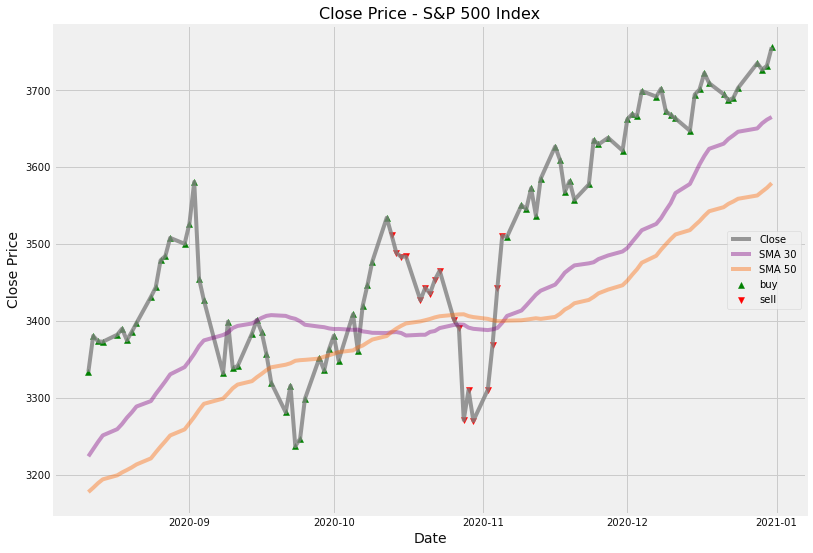

In [130]:
plt.figure(figsize=(12,9))
plt.title("Close Price - S&P 500 Index", fontsize=16)
plt.plot(df2.close[-100:], label = "Close", color="grey", alpha=0.8)

plt.plot(df2.sma30[-100:], label = "SMA 30", color="purple", alpha=0.4)
plt.plot(df2.sma50[-100:], label = "SMA 50", color="#ff6600", alpha=0.4)

truebuyprice = df2.s1Dec.replace(-1,np.NAN) * df2.close # we NAN the sell signals
truesellprice = df2.s1Dec.replace(1,np.NAN) * -1 * df2.close # NAN the buys, mult -1 by -1 to keep price positive

plt.scatter(df2.index[-100:], truebuyprice[-100:], color="green", marker="^", label="buy")
plt.scatter(df2.index[-100:], truesellprice[-100:], color="red", marker="v", label="sell")

plt.xlabel("Date", fontsize=14)
plt.ylabel("Close Price", fontsize=14)
plt.legend(loc="center right")
plt.show()

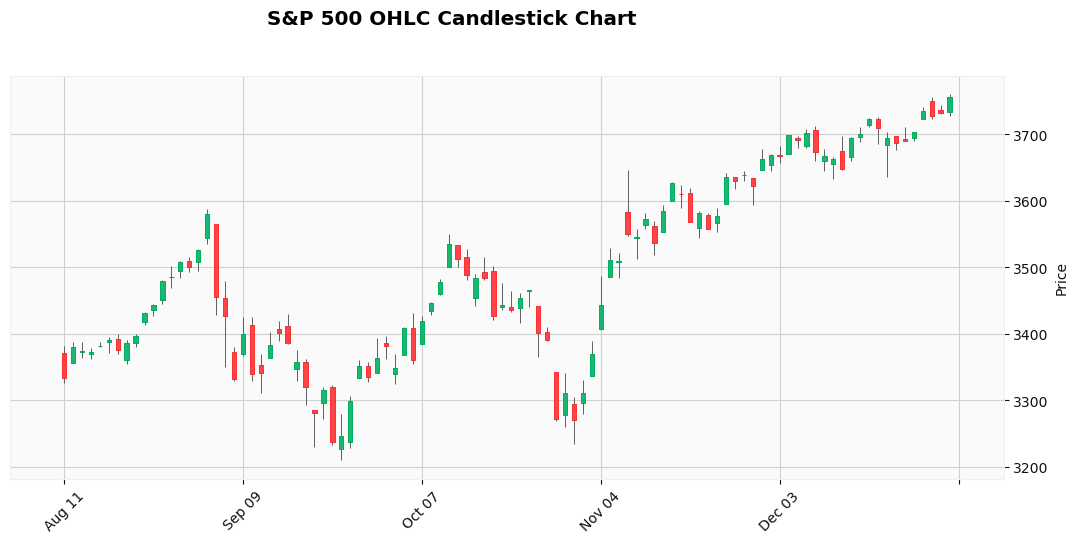

In [131]:
# OHLC graphs
import mplfinance as mpf

ohlc_slice = df2[["open","high","low","close"]][-100:]

mpf.plot(ohlc_slice, type="candle", style="yahoo", figratio=(12,5),
         title="S&P 500 OHLC Candlestick Chart")

In [132]:
""" # draft function
def portRet(pctRetSeries,decSeries,alloc=100000,pos_size=1000,fee_rate=0.001):
    funds=alloc # 100K USD
    fee_cost = fee_rate * pos_size # 0.1% of 1000 is 1 $1 fee per position
    portPos = {"long":0,"short":0} # no open positions
    
    def emptyPortfolio(): return (portPos["long"] == 0 & portPos["short"] == 0)
    def canAfford(): return ((pos_size + fee_cost) <= funds)
    
    
    # when we see 1, 0, or -1, we go long, hold, or short, one position
    # we also close out any other open positions
    for xRet,yDec in zip(pctRetSeries,decSeries):
        if emptyPortfolio():
            if canAfford():
                if yDec == 1:
                    portPos["long"] += 1
                elif yDec == -1:
                    portPos["short"] += 1
                if yDec != 0:
                    funds = funds - (pos_size +  fee_cost)
            # else would mean we can't afford to trade today
            # since the portfolio is also empty, nothign to do
        # there are open positions in the portfolio
        else:
            # we can afford to trade
            if canAfford():
                pass
            # we can't afford to trade
            else:
                pass
"""

' # draft function\ndef portRet(pctRetSeries,decSeries,alloc=100000,pos_size=1000,fee_rate=0.001):\n    funds=alloc # 100K USD\n    fee_cost = fee_rate * pos_size # 0.1% of 1000 is 1 $1 fee per position\n    portPos = {"long":0,"short":0} # no open positions\n    \n    def emptyPortfolio(): return (portPos["long"] == 0 & portPos["short"] == 0)\n    def canAfford(): return ((pos_size + fee_cost) <= funds)\n    \n    \n    # when we see 1, 0, or -1, we go long, hold, or short, one position\n    # we also close out any other open positions\n    for xRet,yDec in zip(pctRetSeries,decSeries):\n        if emptyPortfolio():\n            if canAfford():\n                if yDec == 1:\n                    portPos["long"] += 1\n                elif yDec == -1:\n                    portPos["short"] += 1\n                if yDec != 0:\n                    funds = funds - (pos_size +  fee_cost)\n            # else would mean we can\'t afford to trade today\n            # since the portfolio is also 

In [133]:
def portRet(pctRetSeries, decSeries, alloc=100000, pos_size=1000, fee_rate=0.001):
    cash=alloc # 100K USD
    feeCost = fee_rate * pos_size
    portPos = {"long":0,"short":0}
    portVal = {"long":0,"short":0}
    
    def emptyPortfolio(): return (portPos["long"] == 0 & portPos["short"] == 0)
    # For each pair of rows we track the following:
    # signal, long|long pos ct, short|short pos ct, cash start|end, pctRet, value long|short
    for xRet,yDec in zip(pctRetSeries,decSeries):
        if yDec == 1:
            # subtract from the cash, if we can
            # subtract the fee from the cash value
            
            # add one to the open long positions
            # multiply the position size to the pctRet to get the value
            # add this value to the long value of the portfolio
            if cash >= (pos_size + feeCost):
                cash = cash - pos_size - feeCost
                portPos["long"] += 1
                portVal["long"] = portVal["long"] + (pos_size * np.exp(xRet) )
            
            # now close out any short position
            if portPos["short"] != 0:
                portPos["short"] = 0
                cash += portVal["short"]
                portVal["short"] = 0
                
                cash -= feeCost
            
        elif yDec == 0:
            # check if we have open long or short positions
            # if long is open: multiply pctRet to the current long value
            # if short is open: multiply pctRet to the current short value 
                # short will typically b a negative value, 
                # becuase -short value * -pctReturn = a Posive profit for the short seller
            if not emptyPortfolio():
                # we can only have 1 or mor long or 1 or more short, but never long and short
                # so one of these values will already be zero.
                portVal["long"] = portVal["long"] + (portVal["long"] * np.exp(xRet) )
                portVal["short"] = portVal["short"] + (portVal["short"] * np.exp(xRet) )
        
        elif yDec == -1:
            # (pctRet * -1000) is our new short value
            # we subtract fee from cash
            # add 1 to the short positions
            if cash >= (pos_size + feeCost):
                portVal["short"] = portVal["short"] + (-pos_size * np.exp(xRet) )
                portPos["short"] += 1
                
                cash -= feeCost
            
            # now close out any long position
            if portPos["long"] != 0:
                portPos["long"] = 0
                cash += portVal["long"]
                portVal["long"] = 0
                
                cash -= feeCost
        
    return {"cash":cash, "portPos":portPos, "portVal":portVal}    

In [134]:
df2.columns[7]

'pctRet'

In [135]:
df2.columns[11:]

Index(['s1Dec', 's2Dec_ATR10', 's2Dec_ATR20', 's3Dec_ATR10', 's3Dec_ATR20',
       's4Dec_Atr10_atr10ofAtr10', 's4Dec_Atr10_atr10ofAtr20',
       's4Dec_Atr10_atr20ofAtr10', 's4Dec_Atr10_atr20ofAtr20',
       's4Dec_Atr20_atr10ofAtr10', 's4Dec_Atr20_atr10ofAtr20',
       's4Dec_Atr20_atr20ofAtr10', 's4Dec_Atr20_atr20ofAtr20', 'PnL_s1',
       'PnL_s21', 'PnL_s22', 'PnL_s31', 'PnL_s32', 'PnL_s41aa', 'PnL_s41ab',
       'PnL_s41ba', 'PnL_s41bb', 'PnL_s42aa', 'PnL_s42ab', 'PnL_s42ba',
       'PnL_s42bb'],
      dtype='object')

In [136]:
strategySets = ([ df2.columns[7], df2.columns[11] ], #s1Dec
                
                [ df2.columns[7], df2.columns[12] ], #s2Dec_ATR10
                [ df2.columns[7], df2.columns[13] ],
                
                [ df2.columns[7], df2.columns[14] ], #s3Dec_AT10
                [ df2.columns[7], df2.columns[15] ],
                
                [ df2.columns[7], df2.columns[16] ], #s4Dec_Atr10_atr10ofAtr10
                [ df2.columns[7], df2.columns[17] ],
                [ df2.columns[7], df2.columns[18] ],
                [ df2.columns[7], df2.columns[19] ],
                
                [ df2.columns[7], df2.columns[20] ], #s4Dec_Atr20_atr10ofAtr10
                [ df2.columns[7], df2.columns[21] ],
                [ df2.columns[7], df2.columns[22] ],
                [ df2.columns[7], df2.columns[23] ],
               )

- testing portfolio execution funtion on Strategy 1

In [137]:
portRet(df2.pctRet, df2.s1Dec)

{'cash': -71409.350113742,
 'portPos': {'long': 0, 'short': 0},
 'portVal': {'long': 0, 'short': 0}}

In [138]:
portRet(df2.pctRet, df2.s2Dec_ATR10)

{'cash': 9.639114904556676e+21,
 'portPos': {'long': 27, 'short': 0},
 'portVal': {'long': 7145648.886759777, 'short': 0.0}}

In [139]:
# Dictionary Keys to better sort results of the strategies on each portfolio
numz = [1,21,22,31,32,411,412,413,414,421,422,423,424]

In [140]:
# we wil iterate through this to make the dictionary of results
list(zip(numz,strategySets))

[(1, ['pctRet', 's1Dec']),
 (21, ['pctRet', 's2Dec_ATR10']),
 (22, ['pctRet', 's2Dec_ATR20']),
 (31, ['pctRet', 's3Dec_ATR10']),
 (32, ['pctRet', 's3Dec_ATR20']),
 (411, ['pctRet', 's4Dec_Atr10_atr10ofAtr10']),
 (412, ['pctRet', 's4Dec_Atr10_atr10ofAtr20']),
 (413, ['pctRet', 's4Dec_Atr10_atr20ofAtr10']),
 (414, ['pctRet', 's4Dec_Atr10_atr20ofAtr20']),
 (421, ['pctRet', 's4Dec_Atr20_atr10ofAtr10']),
 (422, ['pctRet', 's4Dec_Atr20_atr10ofAtr20']),
 (423, ['pctRet', 's4Dec_Atr20_atr20ofAtr10']),
 (424, ['pctRet', 's4Dec_Atr20_atr20ofAtr20'])]

In [141]:
df2[strategySets[0][0]][:5]

date
2007-03-16   -0.003828
2007-03-19    0.010894
2007-03-20    0.006333
2007-03-21    0.017081
2007-03-22   -0.000348
Name: pctRet, dtype: float64

In [142]:
strategyResults = {num: portRet(df2[x[0]], df2[x[1]]) for num,x in zip(numz, strategySets)}

In [143]:
strategyResults

{1: {'cash': -71409.350113742,
  'portPos': {'long': 0, 'short': 0},
  'portVal': {'long': 0, 'short': 0}},
 21: {'cash': 9.639114904556676e+21,
  'portPos': {'long': 27, 'short': 0},
  'portVal': {'long': 7145648.886759777, 'short': 0.0}},
 22: {'cash': 4.0807443290817835e+22,
  'portPos': {'long': 28, 'short': 0},
  'portVal': {'long': 3888212.88092707, 'short': 0.0}},
 31: {'cash': 4.22768463292593e+16,
  'portPos': {'long': 0, 'short': 27},
  'portVal': {'long': 0, 'short': -27054.30516421793}},
 32: {'cash': 2.317249458883024e+16,
  'portPos': {'long': 0, 'short': 28},
  'portVal': {'long': 0, 'short': -28065.640110464094}},
 411: {'cash': 5.825812997533403e+25,
  'portPos': {'long': 24, 'short': 0},
  'portVal': {'long': 10318911.930649433, 'short': 0.0}},
 412: {'cash': 1.5388778282386768e+26,
  'portPos': {'long': 26, 'short': 0},
  'portVal': {'long': 180497.01950448577, 'short': 0.0}},
 413: {'cash': 1.5388778282386768e+26,
  'portPos': {'long': 26, 'short': 0},
  'portVal': 

In [144]:
strategyResults[21]["cash"]

9.639114904556676e+21

In [145]:
df2.pctRet.cumsum()

date
2007-03-16   -0.003828
2007-03-19    0.007066
2007-03-20    0.013400
2007-03-21    0.030481
2007-03-22    0.030132
                ...   
2020-12-24    1.280209
2020-12-28    1.288932
2020-12-29    1.286705
2020-12-30    1.288046
2020-12-31    1.294485
Name: pctRet, Length: 3475, dtype: float64

# ----

In [146]:
smallSet = df2[:10]

In [147]:
smallSet

,open,high,low,close,adjClose,sma30,sma50,pctRet,true_range,ATR10,...,PnL_s31,PnL_s32,PnL_s41aa,PnL_s41ab,PnL_s41ba,PnL_s41bb,PnL_s42aa,PnL_s42ab,PnL_s42ba,PnL_s42bb
date,,,,,,,,,,,,,,,,,,,,,
2007-03-16,1392.280029,1397.510010,1383.630005,1386.949951,1386.949951,1425.722343,1425.097800,-0.003828,10.569946,17.218994,...,0.003828,0.003828,-0.003828,-0.000000,-0.000000,-0.000000,-0.003828,-0.000000,-0.000000,-0.000000
2007-03-19,1386.949951,1403.199951,1386.949951,1402.060059,1402.060059,1423.756010,1424.504800,0.010894,13.880005,16.953992,...,0.010894,0.010894,-0.010894,0.000000,0.000000,0.000000,-0.010894,0.000000,0.000000,0.000000
2007-03-20,1402.040039,1411.530029,1400.699951,1410.939941,1410.939941,1422.211678,1424.179202,0.006333,16.250000,16.789990,...,0.006333,0.006333,-0.006333,0.000000,0.000000,0.000000,-0.006333,0.000000,0.000000,0.000000
2007-03-21,1410.920044,1437.770020,1409.750000,1435.040039,1435.040039,1421.010010,1424.203801,0.017081,10.830078,15.489001,...,0.017081,0.017081,-0.017081,-0.017081,-0.017081,-0.017081,-0.017081,0.000000,0.000000,0.000000
2007-03-22,1435.040039,1437.660034,1429.880005,1434.540039,1434.540039,1420.578011,1424.647803,-0.000348,28.020020,17.239002,...,-0.000000,-0.000000,0.000348,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
2007-03-23,1434.540039,1438.890015,1433.209961,1436.109985,1436.109985,1420.062012,1425.096404,0.001094,7.780029,16.412000,...,0.001094,0.001094,-0.001094,-0.001094,-0.001094,-0.001094,0.000000,0.000000,0.000000,0.000000
2007-03-26,1436.109985,1437.650024,1423.280029,1437.500000,1437.500000,1419.655343,1425.521604,0.000968,5.680054,15.695007,...,0.000968,0.000968,-0.000968,-0.000968,-0.000968,-0.000968,0.000000,0.000000,0.000000,0.000000
2007-03-27,1437.489990,1437.489990,1425.540039,1428.609985,1428.609985,1419.636674,1425.795205,-0.006184,14.369995,16.038013,...,-0.006184,-0.006184,0.006184,0.006184,0.006184,0.006184,-0.000000,-0.000000,-0.000000,-0.000000
2007-03-28,1428.349976,1428.349976,1414.069946,1417.229980,1417.229980,1419.478007,1425.752805,-0.007966,11.959961,14.345007,...,-0.007966,-0.007966,0.007966,0.007966,0.007966,0.007966,0.007966,0.007966,0.007966,0.007966


In [148]:
smallSet.iloc[:,11:16]

,s1Dec,s2Dec_ATR10,s2Dec_ATR20,s3Dec_ATR10,s3Dec_ATR20
date,,,,,
2007-03-16,1,1,1,-1,-1
2007-03-19,-1,-1,-1,1,1
2007-03-20,-1,-1,-1,1,1
2007-03-21,-1,-1,-1,1,1
2007-03-22,-1,0,0,0,0
2007-03-23,-1,-1,-1,1,1
2007-03-26,-1,-1,-1,1,1
2007-03-27,-1,-1,-1,1,1
2007-03-28,-1,-1,-1,1,1


In [149]:
smallSet.iloc[:,15:19]

,s3Dec_ATR20,s4Dec_Atr10_atr10ofAtr10,s4Dec_Atr10_atr10ofAtr20,s4Dec_Atr10_atr20ofAtr10
date,,,,
2007-03-16,-1,1,0,0
2007-03-19,1,-1,0,0
2007-03-20,1,-1,0,0
2007-03-21,1,-1,-1,-1
2007-03-22,0,-1,0,0
2007-03-23,1,-1,-1,-1
2007-03-26,1,-1,-1,-1
2007-03-27,1,-1,-1,-1
2007-03-28,1,-1,-1,-1


In [150]:
smallSet.iloc[:,18:22]

,s4Dec_Atr10_atr20ofAtr10,s4Dec_Atr10_atr20ofAtr20,s4Dec_Atr20_atr10ofAtr10,s4Dec_Atr20_atr10ofAtr20
date,,,,
2007-03-16,0,0,1,0
2007-03-19,0,0,-1,0
2007-03-20,0,0,-1,0
2007-03-21,-1,-1,-1,0
2007-03-22,0,0,0,0
2007-03-23,-1,-1,0,0
2007-03-26,-1,-1,0,0
2007-03-27,-1,-1,0,0
2007-03-28,-1,-1,-1,-1


In [151]:
smallSet.iloc[:,21:24]

,s4Dec_Atr20_atr10ofAtr20,s4Dec_Atr20_atr20ofAtr10,s4Dec_Atr20_atr20ofAtr20
date,,,
2007-03-16,0,0,0
2007-03-19,0,0,0
2007-03-20,0,0,0
2007-03-21,0,0,0
2007-03-22,0,0,0
2007-03-23,0,0,0
2007-03-26,0,0,0
2007-03-27,0,0,0
2007-03-28,-1,-1,-1


In [152]:
smallSet.iloc[:,24:29]

,PnL_s1,PnL_s21,PnL_s22,PnL_s31,PnL_s32
date,,,,,
2007-03-16,-0.003828,-0.003828,-0.003828,0.003828,0.003828
2007-03-19,-0.010894,-0.010894,-0.010894,0.010894,0.010894
2007-03-20,-0.006333,-0.006333,-0.006333,0.006333,0.006333
2007-03-21,-0.017081,-0.017081,-0.017081,0.017081,0.017081
2007-03-22,0.000348,-0.000000,-0.000000,-0.000000,-0.000000
2007-03-23,-0.001094,-0.001094,-0.001094,0.001094,0.001094
2007-03-26,-0.000968,-0.000968,-0.000968,0.000968,0.000968
2007-03-27,0.006184,0.006184,0.006184,-0.006184,-0.006184
2007-03-28,0.007966,0.007966,0.007966,-0.007966,-0.007966


In [153]:
smallSet.iloc[:,29:]

,PnL_s41aa,PnL_s41ab,PnL_s41ba,PnL_s41bb,PnL_s42aa,PnL_s42ab,PnL_s42ba,PnL_s42bb
date,,,,,,,,
2007-03-16,-0.003828,-0.000000,-0.000000,-0.000000,-0.003828,-0.000000,-0.000000,-0.000000
2007-03-19,-0.010894,0.000000,0.000000,0.000000,-0.010894,0.000000,0.000000,0.000000
2007-03-20,-0.006333,0.000000,0.000000,0.000000,-0.006333,0.000000,0.000000,0.000000
2007-03-21,-0.017081,-0.017081,-0.017081,-0.017081,-0.017081,0.000000,0.000000,0.000000
2007-03-22,0.000348,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
2007-03-23,-0.001094,-0.001094,-0.001094,-0.001094,0.000000,0.000000,0.000000,0.000000
2007-03-26,-0.000968,-0.000968,-0.000968,-0.000968,0.000000,0.000000,0.000000,0.000000
2007-03-27,0.006184,0.006184,0.006184,0.006184,-0.000000,-0.000000,-0.000000,-0.000000
2007-03-28,0.007966,0.007966,0.007966,0.007966,0.007966,0.007966,0.007966,0.007966


In [154]:
smallSet.iloc[:,-6:]

,PnL_s41ba,PnL_s41bb,PnL_s42aa,PnL_s42ab,PnL_s42ba,PnL_s42bb
date,,,,,,
2007-03-16,-0.000000,-0.000000,-0.003828,-0.000000,-0.000000,-0.000000
2007-03-19,0.000000,0.000000,-0.010894,0.000000,0.000000,0.000000
2007-03-20,0.000000,0.000000,-0.006333,0.000000,0.000000,0.000000
2007-03-21,-0.017081,-0.017081,-0.017081,0.000000,0.000000,0.000000
2007-03-22,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
2007-03-23,-0.001094,-0.001094,0.000000,0.000000,0.000000,0.000000
2007-03-26,-0.000968,-0.000968,0.000000,0.000000,0.000000,0.000000
2007-03-27,0.006184,0.006184,-0.000000,-0.000000,-0.000000,-0.000000
2007-03-28,0.007966,0.007966,0.007966,0.007966,0.007966,0.007966


In [155]:
def debugStrategySets(aDataFrame):
    df2 = aDataFrame.copy()
    sS = ([ df2.columns[7], df2.columns[11] ], #s1Dec

          [ df2.columns[7], df2.columns[12] ], #s2Dec_ATR10
          [ df2.columns[7], df2.columns[13] ],
          
          [ df2.columns[7], df2.columns[14] ], #s3Dec_AT10
          [ df2.columns[7], df2.columns[15] ],

          [ df2.columns[7], df2.columns[16] ], #s4Dec_Atr10_atr10ofAtr10
          [ df2.columns[7], df2.columns[17] ],
          [ df2.columns[7], df2.columns[18] ],
          [ df2.columns[7], df2.columns[19] ],

          [ df2.columns[7], df2.columns[20] ], #s4Dec_Atr20_atr10ofAtr10
          [ df2.columns[7], df2.columns[21] ],
          [ df2.columns[7], df2.columns[22] ],
          [ df2.columns[7], df2.columns[23] ],
         )
    return sS

In [156]:
smallStratSet = debugStrategySets(smallSet)

In [157]:
smallStratSet

(['pctRet', 's1Dec'],
 ['pctRet', 's2Dec_ATR10'],
 ['pctRet', 's2Dec_ATR20'],
 ['pctRet', 's3Dec_ATR10'],
 ['pctRet', 's3Dec_ATR20'],
 ['pctRet', 's4Dec_Atr10_atr10ofAtr10'],
 ['pctRet', 's4Dec_Atr10_atr10ofAtr20'],
 ['pctRet', 's4Dec_Atr10_atr20ofAtr10'],
 ['pctRet', 's4Dec_Atr10_atr20ofAtr20'],
 ['pctRet', 's4Dec_Atr20_atr10ofAtr10'],
 ['pctRet', 's4Dec_Atr20_atr10ofAtr20'],
 ['pctRet', 's4Dec_Atr20_atr20ofAtr10'],
 ['pctRet', 's4Dec_Atr20_atr20ofAtr20'])

In [158]:
type(smallStratSet)

tuple

In [159]:
def debugStrategyResults (tupleOfStrats, aDataFrame, aPortFunc=portRet):
    tOS = tupleOfStrats
    df2 = aDataFrame.copy()
    numzz = [1,21,22,31,32,411,412,413,414,421,422,423,424]
    sR = {num: aPortFunc(df2[x[0]], df2[x[1]]) for num,x in zip(numzz, tOS)}
    return sR

In [80]:
smallResultSet = debugStrategyResults(smallStratSet, smallSet)

In [89]:
smallResultSet

{1: {'cash': 99985.17900975104,
  'portPos': {'long': 0, 'short': 9},
  'portVal': {'long': 0, 'short': -9025.897497930551}},
 21: {'cash': 99987.17900975104,
  'portPos': {'long': 0, 'short': 7},
  'portVal': {'long': 0, 'short': -7022.499134058296}},
 22: {'cash': 99986.17900975104,
  'portPos': {'long': 0, 'short': 8},
  'portVal': {'long': 0, 'short': -8026.2458595726985}},
 31: {'cash': 91994.82099024896,
  'portPos': {'long': 7, 'short': 0},
  'portVal': {'long': 20149.631410978916, 'short': 0.0}},
 32: {'cash': 90993.82099024896,
  'portPos': {'long': 8, 'short': 0},
  'portVal': {'long': 11059.723937807084, 'short': 0.0}},
 411: {'cash': 99985.17900975104,
  'portPos': {'long': 0, 'short': 9},
  'portVal': {'long': 0, 'short': -9025.897497930551}},
 412: {'cash': 99994.0,
  'portPos': {'long': 0, 'short': 6},
  'portVal': {'long': 0, 'short': -6008.938259612981}},
 413: {'cash': 99994.0,
  'portPos': {'long': 0, 'short': 6},
  'portVal': {'long': 0, 'short': -6008.938259612981}

In [161]:
def pR2(pctRetSeries, decSeries, alloc=100000, pos_size=1000, fee_rate=0.001):
    funds=alloc
    
    for ret, dec in zip(pctRetSeries,decSeries):
        if dec==1:
            # buying
            funds = funds - pos_size
            gain = gain + (pos_size * ret)
            lpos = lpos + 1
            # selling
            if spos:
                
        if dec==-1:
            funds = funds
            gain = gain + 1000
            spos = spos + 1
            

IndentationError: expected an indented block (<ipython-input-161-f81d64df8296>, line 13)

# ----

<font face="Nunito" size=4>VIII. Profit and Loss Examination</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>